extracting tic profiles


Reading TIC for: 20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep01
  -> saved F:\test\20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep01__TIC.csv

Reading TIC for: 20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep02
  -> saved F:\test\20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep02__TIC.csv

Reading TIC for: 20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep03
  -> saved F:\test\20220315_chm134_Cirrhosis_FlowChip15_AA13001EM1_TreatmentA_biorep01_techrep03__TIC.csv

Reading TIC for: 20220315_chm134_Cirrhosis_FlowChip15_AA21013EM1_TreatmentC_biorep13_techrep01
  -> saved F:\test\20220315_chm134_Cirrhosis_FlowChip15_AA21013EM1_TreatmentC_biorep13_techrep01__TIC.csv

Reading TIC for: 20220315_chm134_Cirrhosis_FlowChip15_AA21013EM1_TreatmentC_biorep13_techrep02
  -> saved F:\test\20220315_chm134_Cirrhosis_FlowChip15_AA21013EM1_TreatmentC_biorep13_techrep02

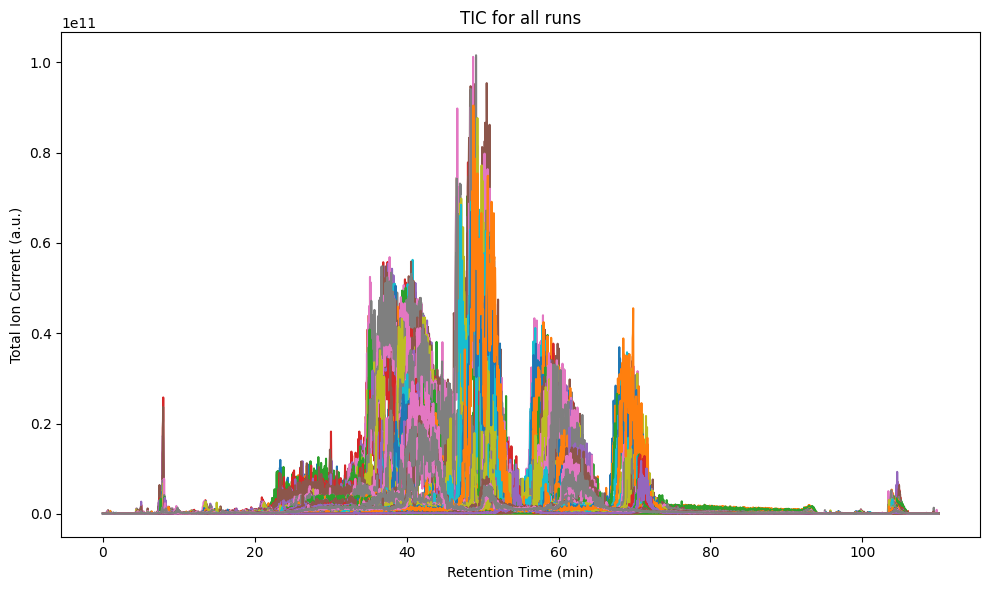

In [1]:
# Read TICs from Thermo .RAW files using fisher_py
# Folder: F:\TreatmentABC
# Output: F:\test

import os, glob, csv
from pathlib import Path
import matplotlib.pyplot as plt
from fisher_py import RawFile
from fisher_py.data.business import TraceType  # has .TIC, .BasePeak, etc.

RAW_FOLDER = r"F:\TreatmentABC"    # folder containing *.raw
OUT_FOLDER = r"F:\test"             # output folder
PLOT_ALL   = True                   # set False to skip plotting

os.makedirs(OUT_FOLDER, exist_ok=True)

raw_paths = sorted(glob.glob(os.path.join(RAW_FOLDER, "*.raw")))
if not raw_paths:
    raise FileNotFoundError(f"No .raw files found in: {RAW_FOLDER}")

all_series = []
skipped = []

for raw_path in raw_paths:
    stem = Path(raw_path).stem
    print(f"\nReading TIC for: {stem}")

    try:
        rf = RawFile(raw_path)
        rt, tic = rf.get_chromatogram(0, 0, TraceType.TIC)

        out_csv = Path(OUT_FOLDER, f"{stem}__TIC.csv")
        with open(out_csv, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["time_min", "intensity"])
            w.writerows(zip(rt, tic))

        print(f"  -> saved {out_csv}")
        all_series.append((stem, rt, tic))

    except Exception as e:
        print(f"  !! Skipping {stem}: {type(e).__name__} - {e}")
        skipped.append(stem)
        continue

# Summary
print("\n=== Processing complete ===")
print(f"Total files: {len(raw_paths)}")
print(f"Processed successfully: {len(all_series)}")
print(f"Skipped: {len(skipped)}")
if skipped:
    print("Skipped files:")
    for s in skipped:
        print(f"  - {s}")

# Optional: plot all TICs
if PLOT_ALL and all_series:
    plt.figure(figsize=(10, 6))
    for label, rt, tic in all_series:
        plt.plot(rt, tic, label=label)
    plt.xlabel("Retention Time (min)")
    plt.ylabel("Total Ion Current (a.u.)")
    plt.title("TIC for all runs")
    #plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
elif PLOT_ALL:
    print("No valid TICs to plot (all files failed).")


returning summed tics

In [17]:
# === Summarize TIC CSVs into a single AUC summary ===
# Input: folder with <run>__TIC.csv files
# Output: one summary CSV listing file name and integrated AUC of TIC

import os, glob
from pathlib import Path
import pandas as pd
import numpy as np

# ---------------- CONFIG ----------------
TIC_FOLDER = Path(r"F:\tic")   # <-- change to your folder
OUT_FILE   = TIC_FOLDER / "TIC_AUC_summary.csv"
# ----------------------------------------

files = sorted(glob.glob(str(TIC_FOLDER / "*__TIC.csv")))
if not files:
    raise FileNotFoundError(f"No TIC CSVs found in {TIC_FOLDER}")

rows = []

def read_tic_csv(path):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    # Try to find the time and intensity columns
    time_col = next((cols[c] for c in cols if "time" in c), df.columns[0])
    inten_col = next((cols[c] for c in cols if "intensity" in c), df.columns[1])
    rt = pd.to_numeric(df[time_col], errors="coerce").dropna().to_numpy()
    ic = pd.to_numeric(df[inten_col], errors="coerce").fillna(0).to_numpy()
    return rt, ic

for f in files:
    name = Path(f).stem.replace("__TIC", "")
    try:
        rt, tic = read_tic_csv(f)
        if len(rt) < 2:
            auc = np.nan
        else:
            # Use trapezoidal integration for AUC
            auc = np.trapz(tic, rt)
        rows.append({"file_name": name, "auc_total_ion": auc})
    except Exception as e:
        rows.append({"file_name": name, "auc_total_ion": np.nan, "error": str(e)})

summary = pd.DataFrame(rows)
summary.to_csv(OUT_FILE, index=False)
print(f"✅ Wrote summary: {OUT_FILE}")
print(summary)


✅ Wrote summary: F:\tic\TIC_AUC_summary.csv
                                             file_name  auc_total_ion
0    20220315_chm134_Cirrhosis_FlowChip15_AA13001EM...   3.505137e+11
1    20220315_chm134_Cirrhosis_FlowChip15_AA13001EM...   3.404392e+11
2    20220315_chm134_Cirrhosis_FlowChip15_AA13001EM...   3.597680e+11
3    20220315_chm134_Cirrhosis_FlowChip15_AA21013EM...   5.522401e+11
4    20220315_chm134_Cirrhosis_FlowChip15_AA21013EM...   4.780496e+11
..                                                 ...            ...
113  20221111_chm134_Cirrhosis_FlowChip15_AG2640BC1...   2.979758e+10
114  20221111_chm134_Cirrhosis_FlowChip15_AG2640BC1...   2.959425e+10
115  20230403_chm134_Cirrhosis_FlowChip15_AA26016EM...   1.677621e+11
116  20230403_chm134_Cirrhosis_FlowChip15_AA26016EM...   1.386283e+11
117  20230403_chm134_Cirrhosis_FlowChip15_AA26016EM...   1.444626e+11

[118 rows x 2 columns]


In [1]:
# --- Normalize all `cast_*` columns by `tic`, excluding ['bin', 'target', 'batch'] ---

import pandas as pd
import numpy as np
from pathlib import Path

# =====================
# CONFIGURATION
# =====================
INPUT_CSV = r"F:/20251010/dataset_rt_batch_tic.csv"   # <-- change this to your CSV file
OUTPUT_CSV = None                             # leave None to auto-name it
FILLNA = None                                 # e.g. 0.0 to replace NaN/inf with 0
FORCE_FLOAT32 = True                          # reduce file size
EXCLUDE_COLS = ["bin", "target", "batch"]     # columns to skip

# =====================
# LOAD CSV
# =====================
in_path = Path(INPUT_CSV)
if not in_path.exists():
    raise FileNotFoundError(f"Input CSV not found: {in_path}")

df = pd.read_csv(in_path)
print(f"Loaded: {in_path}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# =====================
# IDENTIFY COLUMNS
# =====================
tic_candidates = [c for c in df.columns if c.lower() == "tic"]
if not tic_candidates:
    raise KeyError("No 'tic' column found in the CSV (case-insensitive match).")
tic_col = tic_candidates[0]

cast_cols = [
    c for c in df.columns
    if c.lower().startswith("cast_") and c.lower() not in [e.lower() for e in EXCLUDE_COLS]
]

if not cast_cols:
    print("Warning: No eligible 'cast_*' columns found for normalization.")
else:
    print(f"TIC column: {tic_col}")
    print(f"Found {len(cast_cols)} cast_* columns to normalize.")

# =====================
# NORMALIZATION
# =====================
def normalize_cast_by_tic(df, tic_col, cast_cols, fillna=None, to_float32=True):
    result = df.copy()
    denom = pd.to_numeric(df[tic_col], errors="coerce").to_numpy()
    zero_mask = np.isfinite(denom) & (denom == 0)

    for col in cast_cols:
        num = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)
        out = np.divide(
            num,
            denom,
            out=np.full_like(num, np.nan, dtype=float),
            where=~np.isnan(denom)
        )
        out[zero_mask] = np.inf
        if to_float32:
            out = out.astype(np.float32, copy=False)
        result[col] = out

    if fillna is not None:
        result[cast_cols] = result[cast_cols].replace([np.inf, -np.inf], np.nan).fillna(fillna)
    return result


normalized = normalize_cast_by_tic(df, tic_col, cast_cols, fillna=FILLNA, to_float32=FORCE_FLOAT32)

# =====================
# SAVE OUTPUT
# =====================
out_path = Path(OUTPUT_CSV) if OUTPUT_CSV else in_path.with_name(in_path.stem + "_normalized.csv")
normalized.to_csv(out_path, index=False)
print(f"✅ Saved normalized file to: {out_path}")

# =====================
# PREVIEW RESULTS
# =====================
preview_cols = [tic_col] + cast_cols[: min(10, len(cast_cols))]
display(normalized[preview_cols].head(10))


Loaded: F:\20251010\dataset_rt_batch_tic.csv
Shape: 944 rows × 13694 columns
TIC column: tic
Found 13690 cast_* columns to normalize.
✅ Saved normalized file to: F:\20251010\dataset_rt_batch_tic_normalized.csv


,tic,cast_00000,cast_00001,cast_00002,cast_00003,cast_00004,cast_00005,cast_00006,cast_00007,cast_00008,cast_00009
0,0.306408,5.024476e+06,5.704924e+06,13497783.00,2.209323e+07,1.031812e+07,4.288054e+06,4.588285e+06,5.656672e+06,5.579722e+06,7069407.000
1,0.295979,4.992402e+06,5.885649e+06,15609309.00,3.060351e+07,1.206465e+07,5.350354e+06,4.643238e+06,5.177001e+06,6.504758e+06,5327627.500
2,0.249945,7.503692e+06,9.396609e+06,19291248.00,2.902414e+07,1.353542e+07,6.572408e+06,6.873654e+06,7.101295e+06,1.347684e+07,7010359.000
3,0.782942,2.155012e+06,2.786648e+06,3146229.25,1.109691e+07,4.429453e+06,1.746924e+06,3.053295e+06,2.553952e+06,3.615058e+06,5898440.500
4,0.797174,2.412082e+06,2.394266e+06,3570180.00,1.064682e+07,2.917828e+06,1.936870e+06,2.214697e+06,2.940305e+06,3.874496e+06,3378398.750
5,0.620521,4.065569e+06,3.634111e+06,4099220.75,1.076148e+07,4.144774e+06,2.154322e+06,3.015772e+06,2.682864e+06,7.303460e+06,5495600.000
6,1.902976,4.861144e+05,6.644141e+05,1312878.00,2.080666e+06,1.941474e+06,5.370086e+05,5.139527e+05,5.622164e+05,9.542877e+05,1757929.625
7,1.567642,7.462402e+05,9.009179e+05,2093608.00,4.230184e+06,2.014472e+06,7.416152e+05,7.275784e+05,6.918848e+05,1.098665e+06,1434417.500
8,1.557914,7.231648e+05,1.041398e+06,1810039.00,5.263524e+06,1.941286e+06,6.325640e+05,8.787511e+05,6.454583e+05,9.390808e+05,1094072.625
9,0.521532,1.327264e+06,1.575344e+06,2578714.50,6.721802e+06,6.915730e+06,1.407365e+06,1.411755e+06,1.386423e+06,2.207546e+06,2581624.250
